In [1]:
import pandas as pd 
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import random
import os 

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import cv2
import time

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import copy 

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [ ]:
os.listdir('/tf/notebooks/data/bone/')

In [3]:
# case 2,3 : different input, same label(bmd), same network
ct = np.load('/tf/notebooks/data/bone/256d1_2239.npy')
test_ct = np.load('/tf/notebooks/data/bone/256d1_457.npy')
bmd = np.load('/tf/notebooks/data/bone/bmd2239.npy')
test_bmd = np.load('/tf/notebooks/data/bone/bmd457.npy')
tsc = np.load('/tf/notebooks/data/bone/tsc2239c.npy')
test_tsc = np.load('/tf/notebooks/data/bone/tsc457c.npy')

In [4]:
print(np.max(bmd), np.min(bmd), np.max(test_bmd), np.min(test_bmd))
print(ct.shape, bmd.shape, tsc.shape, test_ct.shape, test_bmd.shape, test_tsc.shape)

1.355 0.48 1.192 0.546
(2239, 256, 256, 1) (2239,) (2239,) (457, 256, 256, 1) (457,) (457,)


In [ ]:
ys, xs, patches = plt.hist(bmd, bins=np.arange(0.4,1.5,0.1), color='lime', alpha=0.4, edgecolor='black', rwidth=0.25)
ys1, xs1, patches1 = plt.hist(test_bmd, bins=np.arange(0.4,1.5,0.1), color='lime', alpha=0.4, edgecolor='black', rwidth=0.25)

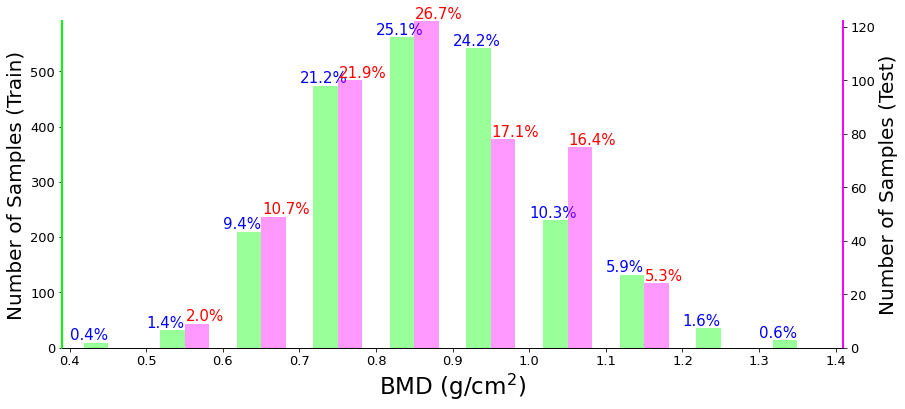

In [8]:
bar_width = 0.16
nsample_test = np.array([  0.,   9.,  49., 100., 122.,  78.,  75.,  24.,   0.,   0.])
nsample_train = np.array([  9.,  31., 210., 474., 562., 542., 230., 132.,  35.,  14.])

index = np.arange(0.45,1.45,0.1)

fig, ax1 = plt.subplots(figsize=(14,6))
b1= ax1.bar(index - bar_width/10, nsample_train, bar_width/5, alpha=0.4, color='lime', label='Train')
ax1.spines['top'].set_visible(False)
for i in range(0, len(ys)):
    plt.text(x=xs[i]+(-0.000), y=ys[i]+5, 
             s='{:0>.1f}%'.format(ys[i]*100/2239), ## percent and location
              ## 문자 
             fontsize=15,
             color='blue',)
plt.xticks(fontsize=13)
    

plt.ylabel('Number of Samples (Train)', fontsize = 20)
plt.xlabel('BMD (g/cm$^{2}$)', fontsize = 23)
plt.yticks(fontsize=13)

ax2 = ax1.twinx()
b2= ax2.bar(index + bar_width/10, nsample_test, bar_width/5, alpha=0.4, color='magenta', label='Test')
for i in range(1, len(ys1)-2):
    plt.text(x=xs1[i]+0.051, y=ys1[i]+1, 
             s='{:0>.1f}%'.format(ys1[i]*100/457), ## percent and location
             fontsize=15,
             color='red')

ax2.spines['left'].set_color('lime')
ax2.spines['left'].set_linewidth(2)
ax2.spines['right'].set_color('magenta')
ax2.spines['right'].set_linewidth(2)
ax2.spines['top'].set_visible(False)
plt.xticks(np.arange(0.4,1.5,0.1))
plt.yticks(fontsize=13)
# ax2.tick_params(axis='y', direction='in')
# x축, y축 이름 및 범례 설정
plt.ylabel('Number of Samples (Test)', fontsize = 20)

# plt.legend(fontsize=12)
# y_min, y_max = plt.ylim()
plt.ylim([0,122])
plt.xlim([0.39,1.41])
plt.xticks(fontsize=13)
plt.show()

In [ ]:
bmdx = np.arange(0.45,1.45,0.1)
bmdy = len(bmd)/(10*ys)
coef2 = np.polyfit(bmdx,bmdy,2)
coef3 = np.polyfit(bmdx,bmdy,3)
coef4 = np.polyfit(bmdx,bmdy,4)
def poly2(x):
    return coef2[0]*x**2+coef2[1]*x+coef2[2]
def poly3(x):
    return coef3[0]*x**3+coef3[1]*x**2+coef3[2]*x+coef3[3]
def poly4(x):
    return coef4[0]*x**4+coef4[1]*x**3+coef4[2]*x**2+coef4[3]*x+coef4[4]
xr = np.linspace(0.45,1.35,100)
plt.plot(bmdx,bmdy, label='weight by histogram')
plt.plot(xr,poly2(xr), label='poly2')
plt.plot(xr,poly3(xr), label='poly3')
plt.plot(xr,poly4(xr), label='poly4')
plt.legend()
print(bmdy)

In [ ]:
def poly3corr(x):
    return 1/10*(coef3[0]*x**3+coef3[1]*x**2+coef3[2]*x+coef3[3])
a = poly3corr(xr)
np.max(a), np.min(a)
def poly3c(x):
    return 1/10*(coef3[0]*x**3+coef3[1]*x**2+coef3[2]*x+coef3[3])-np.min(a)+1
plt.plot(bmdx,bmdy, label='weight by histogram')
plt.plot(xr,poly3corr(xr), label='poly3corr')
plt.plot(xr,poly3c(xr), label='poly3c')
plt.legend()
print(poly3c(bmdx))
print(bmdy)

In [ ]:
def poly2corr(x):
    return 1/8*(coef2[0]*x**2+coef2[1]*x+coef2[2])
def poly2c(x):
    return 1/8*(coef2[0]*x**2+coef2[1]*x+coef2[2])-np.min(poly2corr(xr))+1
plt.plot(bmdx,bmdy, label='weight by histogram')
plt.plot(xr,poly2corr(xr), label='poly2corr')
plt.plot(xr,poly2c(xr), label='poly2c')
plt.legend()
print(poly2c(bmdx))
print(bmdy)

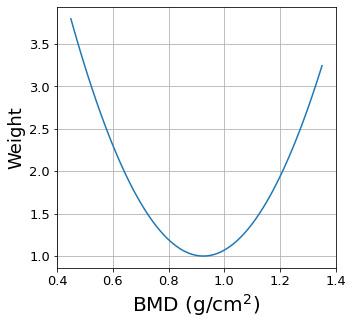

In [12]:
plt.figure(figsize=(5,4.8))
plt.plot(xr,poly2c(xr))
plt.xlabel('BMD (g/cm$^{2}$)',fontsize=20)
plt.ylabel('Weight',fontsize=18)
plt.grid('on')
plt.xlim([0.4, 1.4])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [21]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

# 내가 사용할 GPU번호(0,1,2,3)
os.environ["CUDA_VISIBLE_DEVICES"]="1"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus: 
    try: # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus: 
            tf.config.experimental.set_memory_growth(gpu, True)
             
        logical_gpus = tf.config.experimental.list_logical_devices('GPU') 
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs") 
    
    except RuntimeError as e: # Memory growth must be set before GPUs have been initialized 
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [22]:
seed = 1

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [23]:
# normalize
CT=(ct-np.min(ct))/(np.max(ct)-np.min(ct))
tCT = (test_ct-np.min(test_ct))/(np.max(test_ct)-np.min(test_ct))

In [25]:
test_feature = tCT
# test_bmd = test_bmd
train_feature01 = CT
train_bmd1 = bmd

In [26]:
from tensorflow.keras import backend as K

def poly2huber(threshold):
    def huber_loss(y_true, y_pred):        
        w = poly2c(y_true)
        threshold = 0.05        
        error = y_true - y_pred        
        is_small_error = tf.abs(error) <= threshold        
        small_error_loss = tf.square(error) / 2        
        big_error_loss = threshold * (tf.abs(error) - (0.5 * threshold))        
        return w*tf.where(is_small_error, small_error_loss, big_error_loss)    
    return huber_loss

def poly2mse(y_true,y_pred):
    mse_base = K.square(y_pred-y_true)
    w = poly2c(y_true)
    return w*mse_base

def poly3mse(y_true,y_pred):
    mse_base = K.square(y_pred-y_true)
    w = poly3corr(y_true)
    return w*mse_base

def weightmse1(y_true,y_pred):
    w = 1.6/y_true
    mse_base = K.square(y_pred-y_true)
    return w*mse_base

def weightmse2(y_true,y_pred):
    w = 1.6/K.pow(y_true,2)
    mse_base = K.square(y_pred-y_true)
    return w*mse_base

In [27]:
leaky = tf.keras.layers.LeakyReLU(alpha=0.1)

In [28]:
def res_identity3(x, filters): 
    #full pre-activation

    x_skip = x # this will be used for addition with the residual block 
    f1, f2 = filters

    #first block 
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
        
    #second block # bottleneck (but size kept same with padding)

    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = Conv2D(f2, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)

    # third block activation used after adding the input

    # add the input 
    x = Add()([x, x_skip])

    return x

def res_conv3(x, s, filters):
    '''
    here the input size changes''' 
    x_skip = x
    f1, f2 = filters

    # first block
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)   
    x = Conv2D(f1, kernel_size=(3, 3), strides=(s, s), padding='same')(x)
    # when s = 2 then it is like downsizing the feature map

    # second block
       
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)    
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    
    # shortcut 
#     x_skip = BatchNormalization()(x_skip)
    x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='same')(x_skip)


    # add 
    x = Add()([x, x_skip])

    return x

In [ ]:
#model
def resnet22():
    input_im = Input(shape=(256,256,1)) 

    x = Conv2D(16, kernel_size=(3, 3), strides=2, padding='same')(input_im)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)    

    x = res_conv3(x, s=2, filters=(16, 16))
    x = res_identity3(x, filters=(16, 16))

    x = res_conv3(x, s=2, filters=(32, 32))
    x = res_identity3(x, filters=(32, 32))

    x = res_conv3(x, s=2, filters=(64, 64))
    x = res_identity3(x, filters=(64, 64))
    x = res_identity3(x, filters=(64, 64))

    x = res_conv3(x, s=2, filters=(128, 128))
    x = res_identity3(x, filters=(128, 128))
    x = res_identity3(x, filters=(128, 128))

    x = Conv2D(16, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)  

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(1, activation='linear')(x)

    model = Model(inputs=input_im, outputs=x)

    return model
model = resnet22()

In [ ]:
# i=0~9
batch_size=15
epochs = 150

mcppath = './models/256/bmd2696_orgs1_res22hb_'+str(i)+'.h5'
mcp_save = ModelCheckpoint(mcppath, save_best_only=True, monitor='val_loss', mode='min')
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_loss", 
                        patience = 30, 
                        factor = 0.5,
                        mode = 'min',
                        min_lr=0.001,
                        verbose=1)

callbacks = [mcp_save, learning_rate_reduction]

train_feature, valid_feature, train_bmd, valid_bmd = train_test_split(train_feature01, train_bmd1, test_size=0.2, random_state= i )

In [ ]:
# image data generator
train_datagen=ImageDataGenerator(
        rotation_range=5,
        horizontal_flip=True,
        width_shift_range=0.1, 
        height_shift_range=0.1)

train_generator=train_datagen.flow(
    train_feature, 
    train_bmd,
    batch_size = batch_size )

validate_datagen=ImageDataGenerator()

validation_generator=validate_datagen.flow(
    valid_feature,
    valid_bmd,
    batch_size = batch_size)

model.compile(optimizer='adam', loss=poly2huber(0.1), metrics=[poly2huber(0.1)])